
## <center>Sulfuric Acid Condensation to a Particle Population </center>
<center><span style="font-size: 20px;">Aerosol Standards Case 1 </span></center>
<center>Fixed Parameter Case</center>
<center><span style="font-size: 14px;">Created: September 2025 | Revised: MMM YYYY</span></center>

---

This Jupyter notebook has been created under the Aerosol Model Benchmark Repository and Standards (AMBRS) project. 

AMBRS Code and documentation: https://github.com/AMBRS-project  
Authors: https://github.com/orgs/AMBRS-project/people  

The goals of AMBRS Test Case notebooks are to:
- demonstrate aerosol model predictions and behavior under well-defined conditions.
- explore sensitivity of predictions to critical input and model parameters.
- verify suitability of individual aerosol model algorithms.
- characterize aerosol model performance in the context of other contemporary models.
---

### Standard Case 1 - Origin and Details

This standards case was originally explored by Zhang et al. ([1999](https://www.tandfonline.com/doi/abs/10.1080/027868299304039)) for a multimodel comparison study of sulfuric acid condensation and subsequent particle growth. It was more recently implemented to characterize the SSH-Aerosol model developed by Sartelet et al. (2024; [User Guide: Example 8.1.2](https://cerea.enpc.fr/ssh-aerosol/user_manual.pdf)). 

As documented in Sartelet et al. ([2020](https://www.mdpi.com/2073-4433/11/5/525)), sulfate particles are given a tri-modal initial distribution. A sulfuric acid production rate of 9.9 μg m−3 is assumed, characteristic of hazy conditions. Temperature is 283.15 K and the simulation is conducted for 12 hours. 

---


### Specify Folder Paths

In [1]:
# Path to AMBRS Repo
ambrs_module_path = '/home/bmurphy/AMBRS/repos/ambrs'

# Path for model executables (i.e. where the MAM4 and PartMC binary executables are located)
model_exec_path = '/home/bmurphy/AMBRS/ambrs_builds/bin'

# Path to CAMP configuration files
camp_config_path = '/home/bmurphy/AMBRS/repos/ambrs/camp/s1_config'

# Output Directory Root
output_path = '/home/bmurphy/AMBRS/local_tests/s1_fpc_h2so4cond/output'

### Configure System

In [2]:
# Import system libraries
import sys
import os
import json

# Include critical paths and import AMBRS library
sys.path.insert(0,ambrs_module_path)
import ambrs
from ambrs import constvar as constvar
from ambrs import vol_to_num as vol_to_num

# Import typical Python packages.
import numpy as np
import scipy.stats as stats
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

### Declare Constant Variables

In [3]:
# Simulation parameters
dt = 60. # time step [s]
nsteps = 60 # number of steps

# reference pressure and height
p0 = 101325. # [Pa]
h0 = 1100. # [m]
T0 = 283.15 # [K]
rgas = 1.38065e-23 * 6.02214e26 # [J / K / kmol]
mwdry = 28.966 # [g / mol]

rdair = rgas / mwdry
rwv = rgas / 18.016
# rhodair = p0 / (rdair * T0)

h2so4_form_amt = 5.5 * 1e6 * 1e-18 # [um3 cm-3] -> [m3 m-3]
h2so4_aero_dens = 1.8 * 1e6 * 1e-3 # [g cm-3] -> [kg m-3]
h2so4_molwt = 98.08 * 1e-3 # [g mol-1] -> [kg mol-1]

air_molwt = 28.966 * 1e-3 # [g mol-1] -> [kg mol-1]
air_mol_conc = p0 / (rgas * T0) # [mol m-3]

h2so4_mol_mixrat = ((h2so4_form_amt * h2so4_aero_dens) / h2so4_molwt) / air_mol_conc

timelength_factor = 12.0 * 3600.0 # [s]

h2so4_mol_mixrat_rate = 1e6 * h2so4_mol_mixrat / timelength_factor # [mol mol-1 s-1] -> [ppm s-1]
print(h2so4_mol_mixrat_rate)

h2so4_area_emis = (h2so4_form_amt * h2so4_aero_dens) / h2so4_molwt * h0 / timelength_factor
print(h2so4_area_emis)

5.428819333822298e-05
2.5701808047852094e-09


### Set CAMP Specifications Path
These files include data needed to set properties of particle and gas-phase species in the AMBRS system.

In [4]:
# Read species names from CAMP definitions
with open(f'{camp_config_path}/species.json', 'r') as f: #FIXME: Point to local camp config path
    spec_def = json.load(f)['camp-data']
f.close()

### Define Aerosol and Gas Chemical Species
Use properties like molecular weight, density, kappa, etc. from CAMP to specify properties in the AMBRS system. These properties could alternatively be set manually.

In [5]:
# Define AMBRS aerosol species
# Particulate species of interest. These short-names will be used to look up species properties in CAMP tables.
particulate_species = [
    "SO4",
    "POM",
    "SOA",
    "BC",
    "DST",
    "NCL",
    "MOM"
]
particles = [
    ambrs.AerosolSpecies( 
        name = p['name'],
        molar_mass = 1e3 * p['molecular weight [kg mol-1]'], # Convert [kg/mol] to [g/mol]
        density = p['density [kg m-3]'],
        ions_in_soln = p['num_ions'],
        hygroscopicity = p['kappa'],
    ) for p in spec_def if p['name'] in particulate_species
]
# Define AMBRS gas species
gases = [
    ambrs.GasSpecies(
        name = g['name'],
        molar_mass = 1e3 * g['molecular weight [kg mol-1]'], # Convert [kg/mol] to [g/mol]
    ) for g in spec_def if 'ION_PAIR' not in g.values() and g['name'] not in particulate_species
]

### Select Aerosol Processes

In [6]:
mam_processes__cond_only = ambrs.AerosolProcesses(
    gas_phase_chemistry = True, # CAMP handles H2SO4 emissions
    coagulation = False,
    condensation = True,
    nucleation = False
)

pmc_processes__cond_only = ambrs.AerosolProcesses(
    gas_phase_chemistry = True, # Condensation handled by CAMP
    coagulation = False,
    condensation = False, # This means cloud condensation
    nucleation = False
)

### Specify Test Case Conditions

In [7]:
# Initial size distribution parameters hard-coded in MAM4, do not match Seigneur et al. (1986)
DgnAccum_hazy = 0.24e-6
DgnAitken_hazy = 0.044e-6
DgnCoarse_hazy = 6.0e-6
sigmagAccum_hazy = 1.8
sigmagAitken_hazy = 1.2
sigmagCoarse_hazy = 2.2

# Initial number concentrations derived from volume concentrations and corresponding size parameters
# from Seignuer et al. (1986)
numAccum_hazy = vol_to_num(5.8e-12, DgnAccum_hazy, sigmagAccum_hazy)
numAitken_hazy = vol_to_num(0.09e-12, DgnAitken_hazy, sigmagAitken_hazy)
numCoarse_hazy = vol_to_num(25.9e-12, DgnCoarse_hazy, sigmagCoarse_hazy)

T0 = 283.15 # [K]

### Specify Perturbed Parameter Ensemble

In [ ]:
spec_hazy = ambrs.EnsembleSpecification(
    name = "ppe_spec_hazy",
    aerosols = tuple(particles),
    gases = tuple(gases),
    size = ambrs.AerosolModalSizeDistribution(
        modes = [
            ambrs.AerosolModeDistribution(
                name = "accumulation",
                species = particles,
                number = constvar(numAccum_hazy),
                geom_mean_diam = constvar(DgnAccum_hazy),
                log10_geom_std_dev = constvar(np.log10(sigmagAccum_hazy)),
                mass_fractions = [constvar(1.) if p.name in ['SO4'] else constvar(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "aitken",
                species = particles,
                number = constvar(numAitken_hazy),
                geom_mean_diam = constvar(DgnAitken_hazy),
                log10_geom_std_dev = constvar(np.log10(sigmagAitken_hazy)),
                mass_fractions = [constvar(1.) if p.name in ['SO4'] else constvar(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                name = "coarse",
                species = particles,
                number = constvar(numCoarse_hazy),
                geom_mean_diam = constvar(DgnCoarse_hazy),
                log10_geom_std_dev = constvar(np.log10(sigmagCoarse_hazy)),
                mass_fractions = [constvar(1.) if p.name in ['SO4'] else constvar(0.) for p in particles]
            ),
            ambrs.AerosolModeDistribution(
                # This mode is retained for MAM4 compatibility but is zeroed out
                name = "primary_carbon",
                species = particles,
                number = constvar(0.),
                geom_mean_diam = constvar(0.05e-6),
                log10_geom_std_dev = constvar(np.log10(1.6)),
                mass_fractions = [constvar(1.) if p.name in ['POM'] else constvar(0.) for p in particles]
            ),
        ]
    ),
    #gas_concs = tuple([constvar(1e-3) if g.name=='H2SO4' else constvar(0.) for g in gases]),
    gas_concs = tuple([constvar(0.) for g in gases]),
    gas_emissions = [(i*dt, {g.name:0.0 for g in gases} | 
                      {'rate':1.0, 'H2SO4':2.5701808047852094e-6})
                     for i in range(nsteps)],
    flux = constvar(0.),
    relative_humidity = constvar(0.6), # from Sartelet et al. (2020) coag+cond+nuc
    temperature = constvar(T0),
    pressure = constvar(p0),
    height = constvar(h0),
)

### Run Ensemble Simulations

In [13]:
n = 1
ensemble_hazy = ambrs.lhs(specification=spec_hazy, n=n)
n_part = 1000

# Run MAM
mam4 = ambrs.mam4.AerosolModel(
    processes = mam_processes__cond_only,
    camp_config = f'{camp_config_path}/mam4_config.json',
    camp_mech = 'MAM4_H2SO4_emission',
)
mam4_inputs = mam4.create_inputs(
    ensemble = ensemble_hazy,
    dt = dt,
    nstep = nsteps,
)
mam4_runner = ambrs.PoolRunner(
    model = mam4,
    executable = f'{model_exec_path}/mam4',
    root = output_path + '/hazy/cond_only/mam',
    num_processes = 1,
)
mam_outputs = mam4_runner.run(mam4_inputs)

# Run PMC
partmc = ambrs.partmc.AerosolModel(
    processes = pmc_processes__cond_only,
    n_part = n_part,
    camp_config = camp_config_path + '/partmc_config.json'
)
partmc_inputs = partmc.create_inputs(
    ensemble = ensemble_hazy,
    dt = dt,
    nstep = nsteps,
)
partmc_runner = ambrs.PoolRunner(
    model = partmc,
    executable = model_exec_path + '/partmc',
    root = output_path + '/hazy/cond_only/pmc',
    num_processes = 1,
)
partmc_outputs = partmc_runner.run(partmc_inputs)


mam4: one or more existing scenario directories found. Overwriting contents...


partmc: one or more existing scenario directories found. Overwriting contents...


### Open Output Files and Load Data

In [14]:
mam = xr.open_dataset( output_path + '/hazy/cond_only/mam/1/mam_output.nc')
pmc = xr.open_mfdataset( 
    output_path + '/hazy/cond_only/pmc/1/out/*.nc',
    combine='nested',
    concat_dim='nsteps'
)

### Make figures of Sulfate increase and Sulfuric Acid decrease

Text(0.5, 0, 'Time [min]')

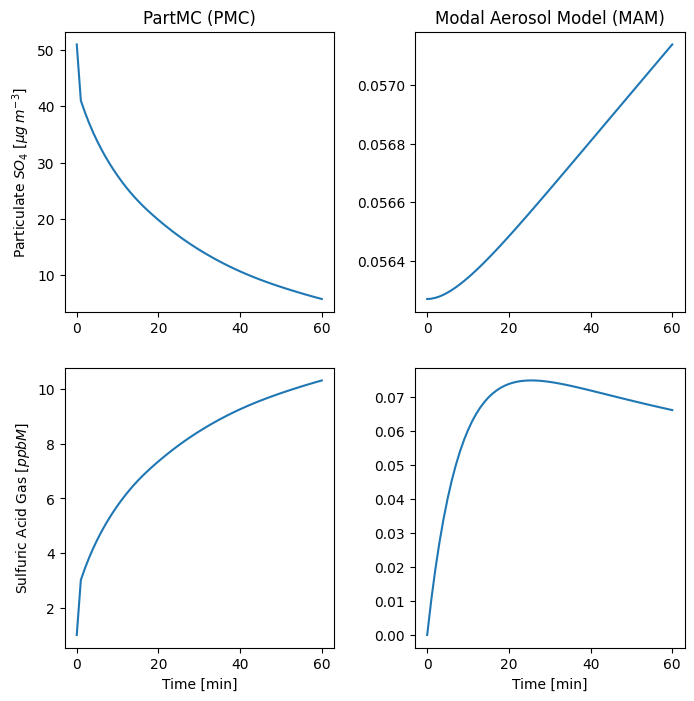

In [15]:
# Retrieve PartMC Results
so4_index = 0
so4_pmc   = 1e9 * (pmc.isel(aero_species=so4_index).aero_particle_mass * \
                 pmc.isel(aero_species=so4_index).aero_num_conc).sum('aero_particle') #ug m-3
h2so4_pmc = pmc.isel(gas_species=2).gas_mixing_ratio # ppb (M or V?) 

# Retrieve MAM4 Results
so4_mam   = 1e9*mam.so4_aer.sum('mode')*(air_mol_conc*air_molwt)  # ug m-3
h2so4_mam = 1e9*mam.h2so4_gas  # ppbM

# Plot Figure
cfig, ax1 = plt.subplots( 2,2, figsize=(8,8), gridspec_kw=dict(wspace=0.3))
ax1[0,0].plot(np.arange(61), so4_pmc)
ax1[0,0].set_ylabel(r'Particulate $SO_4$ $[\mu g \: m^{-3}]$')
ax1[0,0].set_title('PartMC (PMC)')
ax1[0,1].plot(np.arange(61), so4_mam)
ax1[0,1].set_title('Modal Aerosol Model (MAM)')
ax1[1,0].plot(np.arange(61), h2so4_pmc)
ax1[1,0].set_xlabel('Time [min]')
ax1[1,0].set_ylabel('Sulfuric Acid Gas $[ppbM]$')
ax1[1,1].plot(np.arange(61), 1e9*mam.h2so4_gas)
ax1[1,1].set_xlabel('Time [min]')



Text(0.5, 0.98, 'Sulfuric Acid Condensation')

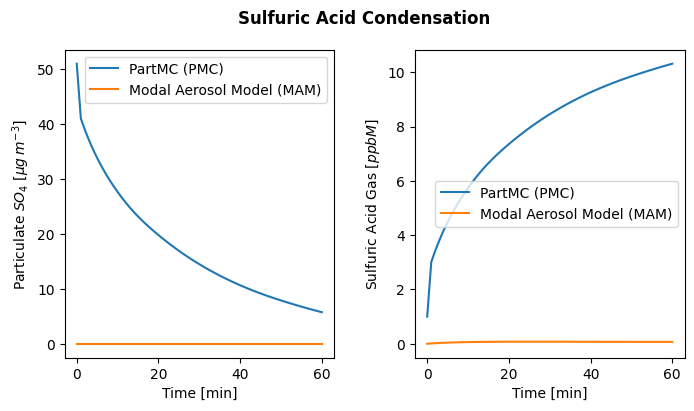

In [ ]:
# Plot

# Retrieve PartMC Results
so4_index = 0
so4_pmc   = 1e9 * (pmc.isel(aero_species=so4_index).aero_particle_mass * \
                 pmc.isel(aero_species=so4_index).aero_num_conc).sum('aero_particle') #ug m-3
h2so4_pmc = pmc.isel(gas_species=2).gas_mixing_ratio # ppb (M or V?) 

# Retrieve MAM4 Results
so4_mam   = 1e9*mam.so4_aer.sum('mode')*(air_mol_conc*air_molwt)  # ug m-3
h2so4_mam = 1e9*mam.h2so4_gas  # ppbM

# Plot Figure
cfig, ax1 = plt.subplots( 1,2, figsize=(8,4), gridspec_kw=dict(wspace=0.3))
ax1[0].plot(np.arange(61), so4_pmc)
ax1[0].plot(np.arange(61), so4_mam)
ax1[0].set_ylabel(r'Particulate $SO_4$ $[\mu g \: m^{-3}]$')
ax1[0].set_xlabel('Time [min]')
ax1[0].legend({"PartMC (PMC)","Modal Aerosol Model (MAM)"})

ax1[1].plot(np.arange(61), h2so4_pmc)
ax1[1].plot(np.arange(61), 1e9*mam.h2so4_gas)
ax1[1].set_ylabel('Sulfuric Acid Gas $[ppbM]$')
ax1[1].set_xlabel('Time [min]')
ax1[1].legend({"PartMC (PMC)","Modal Aerosol Model (MAM)"})

cfig.suptitle('Sulfuric Acid Condensation',fontweight='bold')



### Make Plot of Size Distribution Changes

Text(0.5, 0.98, 'Sulfuric Acid Condensation')

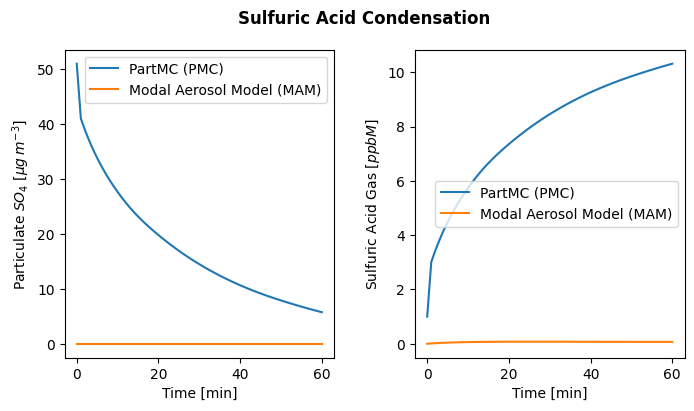

In [ ]:
# Retrieve PartMC Results
so4_index = 0
so4_pmc   = 1e9 * (pmc.isel(aero_species=so4_index).aero_particle_mass * \
                 pmc.isel(aero_species=so4_index).aero_num_conc).sum('aero_particle') #ug m-3
h2so4_pmc = pmc.isel(gas_species=2).gas_mixing_ratio # ppb (M or V?) 

# Retrieve MAM4 Results
so4_mam   = 1e9*mam.so4_aer.sum('mode')*(air_mol_conc*air_molwt)  # ug m-3
h2so4_mam = 1e9*mam.h2so4_gas  # ppbM

# Plot Figure
cfig, ax1 = plt.subplots( 1,2, figsize=(8,4), gridspec_kw=dict(wspace=0.3))
ax1[0].plot(np.arange(61), so4_pmc)
ax1[0].plot(np.arange(61), so4_mam)
ax1[0].set_ylabel(r'Particulate $SO_4$ $[\mu g \: m^{-3}]$')
ax1[0].set_xlabel('Time [min]')
ax1[0].legend({"PartMC (PMC)","Modal Aerosol Model (MAM)"})

ax1[1].plot(np.arange(61), h2so4_pmc)
ax1[1].plot(np.arange(61), 1e9*mam.h2so4_gas)
ax1[1].set_ylabel('Sulfuric Acid Gas $[ppbM]$')
ax1[1].set_xlabel('Time [min]')
ax1[1].legend({"PartMC (PMC)","Modal Aerosol Model (MAM)"})

cfig.suptitle('Sulfuric Acid Condensation',fontweight='bold')



### Make Plot of L2 Norm and KL-divergence for Size Distribution Over Time

In [ ]:
# Retrieve PartMC Results
so4_index = 0
so4_pmc   = 1e9 * (pmc.isel(aero_species=so4_index).aero_particle_mass * \
                 pmc.isel(aero_species=so4_index).aero_num_conc).sum('aero_particle') #ug m-3
h2so4_pmc = pmc.isel(gas_species=2).gas_mixing_ratio # ppb (M or V?) 

# Retrieve MAM4 Results
so4_mam   = 1e9*mam.so4_aer.sum('mode')*(air_mol_conc*air_molwt)  # ug m-3
h2so4_mam = 1e9*mam.h2so4_gas  # ppbM

# Plot Figure
cfig, ax1 = plt.subplots( 1,2, figsize=(8,4), gridspec_kw=dict(wspace=0.3))
ax1[0] = plt.plot(np.arange(61), l2norm)
ax1[0].set_ylabel(r'$L^2$ Norm of Size Distribution')
ax1[0].set_xlabel('Time [min]')

ax1[1] = plt.plot(np.arange(61), kldiv)
ax1[1].set_ylabel(r'KL-divergence of Size Distribution')
ax1[1].set_xlabel('Time [min]')

cfig.suptitle('Size Distribution Statistics',fontweight='bold')

---
### End Standard Test 1